## HR inputting demo
In this notebook, we visualize how the mixture of augmentation (MoA) and CutBlur prevent the SR model from over-sharpening when we provide an HR image as input. We compare the EDSR with MoA and without MoA (baseline).<br>

**Note.** That this is a reproduced code for Figures 2 and 3 of the paper.<br>
However, results may differ (especially baseline) since the result of this code is derived using the final baseline (w/ X2 pre-train strategy) while the baseline model used in the paper is not.

In [1]:
"""
CutBlur
Copyright 2020-present NAVER corp.
MIT license
"""
import sys
sys.path.append("../")
import importlib
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import model.edsr as edsr
%matplotlib inline

# options for EDSR
class Opt:
    scale = 4
    num_blocks = 32
    num_channels = 256
    res_scale = 0.1

def im2tensor(im):
    np_t = np.ascontiguousarray(im.transpose((2, 0, 1)))
    tensor = torch.from_numpy(np_t).float()
    return tensor

def tensor2im(tensor):
    tensor = tensor.detach().squeeze(0)
    im = tensor.clamp(0, 255).round().cpu().byte().permute(1, 2, 0).numpy()
    return im

opt = Opt()
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net_base = edsr.Net(opt).to(dev)
net_moa = edsr.Net(opt).to(dev)

### HR inputting on the RealSR dataset (left example of Figure 2)

In [2]:
path_image = "./inputs/Nikon_006_HR.png"
path_base = "<directory_of_pt>/RealSR_EDSR_X4_base.pt"
path_moa = "<directory_of_pt>/RealSR_EDSR_X4_moa.pt"

state_base = torch.load(path_base, map_location=lambda storage, loc: storage)
state_moa = torch.load(path_moa, map_location=lambda storage, loc: storage)
net_base.load_state_dict(state_base)
net_moa.load_state_dict(state_moa)

LR = io.imread(path_image)
LR_tensor = im2tensor(LR).unsqueeze(0).to(dev)

with torch.no_grad():
    SR_base = tensor2im(net_base(LR_tensor))
    SR_moa = tensor2im(net_moa(LR_tensor))

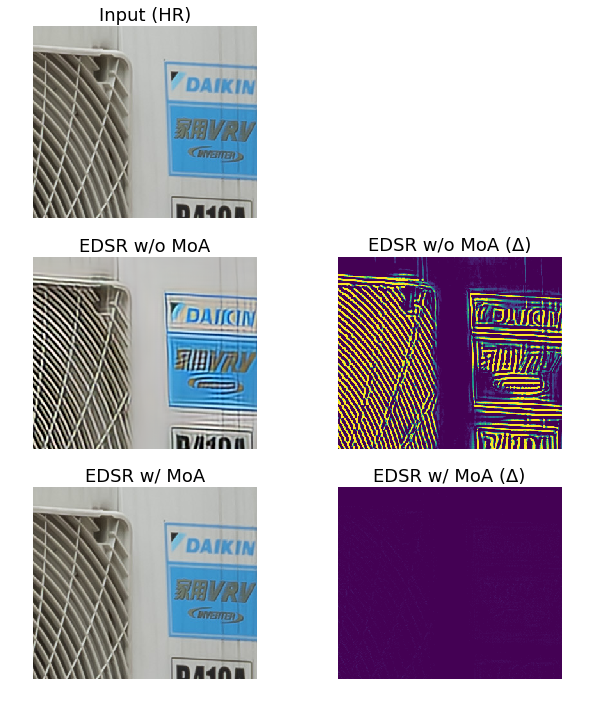

In [3]:
LR_plot = LR[100:400, 750:1100] / 255
SR_base_plot = SR_base[100:400, 750:1100] / 255
SR_moa_plot = SR_moa[100:400, 750:1100] / 255

diff_SR_base = (LR_plot-SR_base_plot).mean(2) * 10
diff_SR_moa = (LR_plot-SR_moa_plot).mean(2) * 10

f, axarr = plt.subplots(3, 2, figsize=(10, 12))
axarr[0, 0].imshow(LR_plot)
axarr[0, 0].set_title("Input (HR)", fontsize=18)
axarr[0, 0].axis("off")
 
axarr[0, 1].axis("off")
 
axarr[1, 0].imshow(SR_base_plot)
axarr[1, 0].set_title("EDSR w/o MoA", fontsize=18)
axarr[1, 0].axis("off")
 
axarr[1, 1].imshow(diff_SR_base, vmin=0, vmax=1, cmap="viridis")
axarr[1, 1].set_title("EDSR w/o MoA (Δ)", fontsize=18)
axarr[1, 1].axis("off")

axarr[2, 0].imshow(SR_moa_plot)
axarr[2, 0].set_title("EDSR w/ MoA", fontsize=18)
axarr[2, 0].axis("off")
 
axarr[2, 1].imshow(diff_SR_moa, vmin=0, vmax=1, cmap="viridis")
axarr[2, 1].set_title("EDSR w/ MoA (Δ)", fontsize=18)
axarr[2, 1].axis("off")

plt.show()

### HR inputting on the DIV2K dataset (right example of Figure 2)

In [4]:
path_image = "./inputs/0869.png"
path_base = "<directory_of_pt>/DIV2K_EDSR_X4_base.pt"
path_moa = "<directory_of_pt>/DIV2K_EDSR_X4_moa.pt"

state_base = torch.load(path_base, map_location=lambda storage, loc: storage)
state_moa = torch.load(path_moa, map_location=lambda storage, loc: storage)
net_base.load_state_dict(state_base)
net_moa.load_state_dict(state_moa)

LR = io.imread(path_image)
LR_tensor = im2tensor(LR).unsqueeze(0).to(dev)

with torch.no_grad():
    SR_base = tensor2im(net_base(LR_tensor))
    SR_moa = tensor2im(net_moa(LR_tensor))

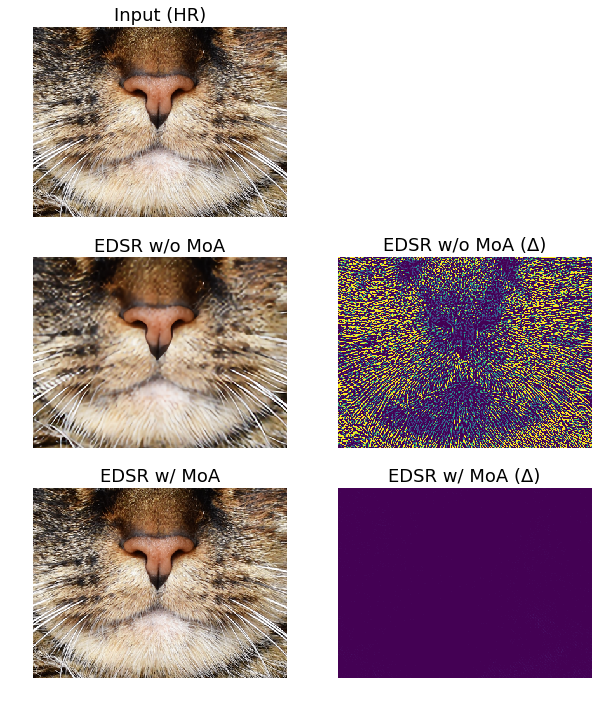

In [5]:
LR_plot = LR[600:900, 550:950] / 255
SR_base_plot = SR_base[600:900, 550:950] / 255
SR_moa_plot = SR_moa[600:900, 550:950] / 255

diff_SR_base = (LR_plot-SR_base_plot).mean(2) * 10
diff_SR_moa = (LR_plot-SR_moa_plot).mean(2) * 10

f, axarr = plt.subplots(3, 2, figsize=(10, 12))
axarr[0, 0].imshow(LR_plot)
axarr[0, 0].set_title("Input (HR)", fontsize=18)
axarr[0, 0].axis("off")
 
axarr[0, 1].axis("off")
 
axarr[1, 0].imshow(SR_base_plot)
axarr[1, 0].set_title("EDSR w/o MoA", fontsize=18)
axarr[1, 0].axis("off")
 
axarr[1, 1].imshow(diff_SR_base, vmin=0, vmax=1, cmap="viridis")
axarr[1, 1].set_title("EDSR w/o MoA (Δ)", fontsize=18)
axarr[1, 1].axis("off")

axarr[2, 0].imshow(SR_moa_plot)
axarr[2, 0].set_title("EDSR w/ MoA", fontsize=18)
axarr[2, 0].axis("off")
 
axarr[2, 1].imshow(diff_SR_moa, vmin=0, vmax=1, cmap="viridis")
axarr[2, 1].set_title("EDSR w/ MoA (Δ)", fontsize=18)
axarr[2, 1].axis("off")

plt.show()

### Cutblurred image inputting on the RealSR dataset (Figure 3)

In [6]:
path_image_HR = "./inputs/Canon_003_HR.png"
path_image_LR = "./inputs/Canon_003_LR4.png"
path_base = "<directory_of_pt>/RealSR_EDSR_X4_base.pt"
path_moa = "<directory_of_pt>/RealSR_EDSR_X4_moa.pt"

state_base = torch.load(path_base, map_location=lambda storage, loc: storage)
state_moa = torch.load(path_moa, map_location=lambda storage, loc: storage)
net_base.load_state_dict(state_base)
net_moa.load_state_dict(state_moa)

HR = io.imread(path_image_HR)
HR_tensor = im2tensor(HR).unsqueeze(0).to(dev)

LR = io.imread(path_image_LR)
LR_tensor = im2tensor(LR).unsqueeze(0).to(dev)

# apply CutBlur
LR_tensor[..., 900:1250, :600] = HR_tensor[..., 900:1250, :600]

with torch.no_grad():
    SR_base = tensor2im(net_base(LR_tensor))
    SR_moa = tensor2im(net_moa(LR_tensor))

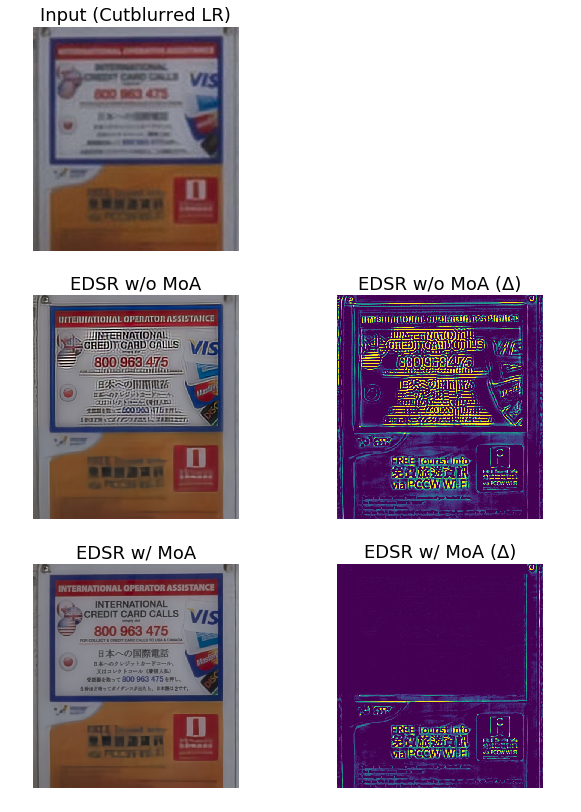

In [7]:
LR_plot = LR[900:1500, 100:650] / 255
HR_plot = HR[900:1500, 100:650] / 255
SR_base_plot = SR_base[900:1500, 100:650] / 255
SR_moa_plot = SR_moa[900:1500, 100:650] / 255

diff_SR_base = (HR_plot-SR_base_plot).mean(2) * 10
diff_SR_moa = (HR_plot-SR_moa_plot).mean(2) * 10

f, axarr = plt.subplots(3, 2, figsize=(10, 14))
axarr[0, 0].imshow(LR_plot)
axarr[0, 0].set_title("Input (Cutblurred LR)", fontsize=18)
axarr[0, 0].axis("off")
 
axarr[0, 1].axis("off")
 
axarr[1, 0].imshow(SR_base_plot)
axarr[1, 0].set_title("EDSR w/o MoA", fontsize=18)
axarr[1, 0].axis("off")
 
axarr[1, 1].imshow(diff_SR_base, vmin=0, vmax=1, cmap="viridis")
axarr[1, 1].set_title("EDSR w/o MoA (Δ)", fontsize=18)
axarr[1, 1].axis("off")

axarr[2, 0].imshow(SR_moa_plot)
axarr[2, 0].set_title("EDSR w/ MoA", fontsize=18)
axarr[2, 0].axis("off")
 
axarr[2, 1].imshow(diff_SR_moa, vmin=0, vmax=1, cmap="viridis")
axarr[2, 1].set_title("EDSR w/ MoA (Δ)", fontsize=18)
axarr[2, 1].axis("off")

plt.show()